# Smoothing with Wave Transform Preprocessing

In [6]:
%load_ext autoreload
%autoreload 2
p = print

import os
import gc
import pickle

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from scipy.fftpack import fft, fftfreq, fftshift
from scipy import signal
import pywt

from crypr.util import get_project_path
from crypr.build import make_single_feature, series_to_predict_matrix, make_features, data_to_supervised
from crypr.wavelets import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
SYM = 'BTC'
TARGET = 'close'
Tx = 72
Ty = 1
TEST_SIZE = 0.05
data_path = os.path.join(get_project_path(), 'data', 'raw', SYM + '.csv')

In [10]:
data = pd.read_csv(data_path, index_col=0)
data.head()

,volumeto,volumefrom,open,high,close,low,time,timestamp
0,6935520.93,1096.93,6314.14,6322.24,6313.66,6290.84,1530471600,2018-07-01 21:00:00
1,24714923.33,3879.19,6313.94,6378.28,6347.37,6298.49,1530475200,2018-07-01 22:00:00
2,9517750.88,1496.49,6347.37,6359.64,6355.81,6331.35,1530478800,2018-07-01 23:00:00
3,12533312.19,1965.11,6355.81,6371.16,6355.41,6346.47,1530482400,2018-07-02 00:00:00
4,13213908.33,2074.03,6355.41,6371.17,6339.04,6337.97,1530486000,2018-07-02 01:00:00


In [11]:
"""
Get percent change feature and target data.
"""
df = make_single_feature(input_df=data, target_col='close')
X, y = data_to_supervised(input_df=df[['target']], Tx=Tx, Ty=Ty)
p(X.shape, y.shape)
X.head()

(5926, 72) (5926, 1)


,var1(t-72),var1(t-71),var1(t-70),var1(t-69),var1(t-68),var1(t-67),var1(t-66),var1(t-65),var1(t-64),var1(t-63),...,var1(t-10),var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1)
73,0.533922,0.132968,-0.006293,-0.257576,-0.071462,-0.155813,0.055023,-0.061788,-0.311818,-0.264097,...,-0.196975,0.217484,0.336705,2.567298,-0.246313,-0.245727,-0.215353,0.153127,-0.045374,0.192814
74,0.132968,-0.006293,-0.257576,-0.071462,-0.155813,0.055023,-0.061788,-0.311818,-0.264097,0.299149,...,0.217484,0.336705,2.567298,-0.246313,-0.245727,-0.215353,0.153127,-0.045374,0.192814,0.082988
75,-0.006293,-0.257576,-0.071462,-0.155813,0.055023,-0.061788,-0.311818,-0.264097,0.299149,0.360255,...,0.336705,2.567298,-0.246313,-0.245727,-0.215353,0.153127,-0.045374,0.192814,0.082988,0.012550
76,-0.257576,-0.071462,-0.155813,0.055023,-0.061788,-0.311818,-0.264097,0.299149,0.360255,-0.052612,...,2.567298,-0.246313,-0.245727,-0.215353,0.153127,-0.045374,0.192814,0.082988,0.012550,-1.429769
77,-0.071462,-0.155813,0.055023,-0.061788,-0.311818,-0.264097,0.299149,0.360255,-0.052612,-0.118716,...,-0.246313,-0.245727,-0.215353,0.153127,-0.045374,0.192814,0.082988,0.012550,-1.429769,-0.126092


In [12]:
"""
Confirm data reshape and target/feature creation was done correctly.
"""
y_values_except_last = np.squeeze(y.iloc[:-1].values)
t_minus_1_x_values_except_first = X.iloc[1:,-1].values

y_values_except_last.all() == t_minus_1_x_values_except_first.all()

True

In [13]:
"""
For comparing different transformations
"""
sample_ix = 1000
sample = X.iloc[sample_ix].values

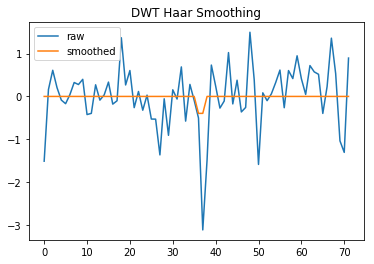

In [14]:
"""
DWT Haar Transform
"""
from crypr.
def dwt_smooth(x, wavelet):
    cA, cD = pywt.dwt(x, wavelet)
    
    def make_threshold(x):
        return np.std(x)*np.sqrt(2*np.log(x.size))
    
    cAt = pywt.threshold(cA, make_threshold(cA), mode="soft")                
    cDt = pywt.threshold(cD, make_threshold(cD), mode="soft")                
    tx = pywt.idwt(cAt, cDt, wavelet)
    return tx

plt.plot(sample, label='raw')
plt.plot(dwt_smooth(sample, 'haar'), label='smoothed')
plt.title('DWT Haar Smoothing')
plt.legend()
plt.show()

In [17]:
"""
Apply the wavelet transformation smoothing to the feature data.
"""
wt_type = 'haar'
X_smooth = np.apply_along_axis(func1d=lambda x: dwt_smooth(x, wt_type), axis=-1, arr=X)

assert X_smooth.shape == X.shape

In [18]:
"""
Train Test Split.
"""
X_train, X_test, y_train, y_test = train_test_split(X_smooth, y, test_size=TEST_SIZE, shuffle=False)

In [14]:
# """
# Save data.
# """
# np.save(arr=X_train, file='../data/processed/X_train_{}_{}_smooth_{}'.format(SYM, wt_type, Tx))
# np.save(arr=X_test,  file='../data/processed/X_test_{}_{}_smooth_{}'.format(SYM, wt_type, Tx))
# np.save(arr=y_train, file='../data/processed/y_train_{}_{}_smooth_{}'.format(SYM, wt_type, Tx))
# np.save(arr=y_test,  file='../data/processed/y_test_{}_{}_smooth_{}'.format(SYM, wt_type, Tx))